In [109]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

In [110]:
# Specify data path and filename(s)
data_dir = os.path.join('..','data', 'nwb2.0')
fname = 'mouse1_fni16_150821_001-002_ch2-PnevPanResults-170808-184141.nwb'

In [111]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

In [112]:
# Extract all trial-based ROI time-series
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

In [113]:
# Display all event-type data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [114]:
# Function to extract trial-based data based on event name, pre/post stimulus duration
def get_trialsegmented_data(event_name, pre_stim_dur, post_stim_dur, roi_series):
    d_obj = roi_series.get(event_name)
    data = np.array(d_obj.data)
    tvec = np.array(d_obj.timestamps)
    # check if pre/post stim duration is out of bound
    pre_stim_dur = tvec[0] if pre_stim_dur < tvec[0] else pre_stim_dur
    post_stim_dur = tvec[-1] if post_stim_dur > tvec[-1] else post_stim_dur    
    # extract data
    data = data[:, ((tvec >= pre_stim_dur) & (tvec <= post_stim_dur)), :]
    timestamps = tvec[((tvec >= pre_stim_dur) & (tvec <= post_stim_dur))]
    return data, timestamps      

In [115]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_data(setting['event'], setting['pre'], setting['post'], roi_series)
    # average
    trial_avg_segments[setting['event']] = (np.nanmean(out[0], axis=2), out[1])

In [116]:
# Obtain inh/exc status of the ROI
roi_tcourse = roi_series.get('initToneAl')
good_roi_mask = roi_tcourse.rois.data
roi_table = roi_tcourse.rois.table
inh_exc = roi_table.get('neuron_type').data[good_roi_mask]

In [117]:
# Function to sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse,axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

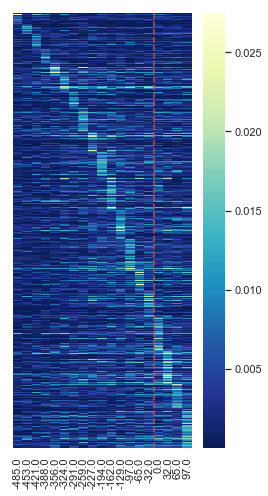

In [118]:
# Raster Plot - plot for inspection
sns.set(rc={'figure.figsize':(4,8)})
sorted_roi_tcourse, sorted_idx = roi_sort_by_peak_latency(trial_avg_segments['initToneAl'][0])
sns.heatmap(data=sorted_roi_tcourse, xticklabels=trial_avg_segments['initToneAl'][1].round(), yticklabels=[],
           cmap='YlGnBu_r')
plt.axvline(x=np.where(trial_avg_segments['initToneAl'][1] == 0), color='r', linestyle='--', linewidth=1.5)

In [119]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit

# Concatenate and sort
data_all = np.hstack([ trial_avg_segments[key][0] for key in trial_avg_segments.keys()])
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)

# Concatenate all timevec(s) and determine the indices of t = 0
tvec_concat = [trial_avg_segments[key][1] for key in trial_avg_segments.keys()]
xdim_all = [t.size for t in tvec_concat]
xdim_all.insert(0,0)
zeros_all = [np.where(v == 0)[0][0] for v in tvec_concat]

# Extract inh/exc status
is_inh = np.zeros((data_all.shape[0]))
is_inh[inh_exc[sorted_roi_idx]=='inhibitory'] = 1

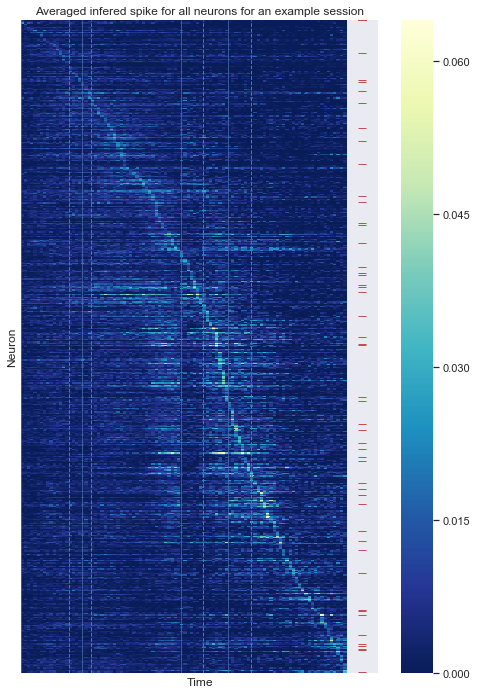

In [120]:
# Raster Plot
sns.set(rc={'figure.figsize':(8,12)})
sns.heatmap(data = data_all,xticklabels = [],yticklabels = [],cmap = 'YlGnBu_r')
# add vertical lines
for zidx, z in enumerate(zeros_all):
    plt.axvline(x= np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    plt.axvline(x= z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
# add inhibitor marker
plt.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5),np.arange(is_inh.size)*is_inh,'r_',markersize=8)
#
plt.xlim((0,data_all.shape[1]+10))
plt.title('Averaged infered spike for all neurons for an example session')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

In [107]:
nwb_io.close()